# Import relevant modules

In [482]:
import xml.etree.ElementTree as ET
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

## Process active motion xml

This is the initialization step where we define the starting folder and ask the user to confirm or change it.

In [483]:
# Define the starting folder path
start_path = r'D:\\Particle tracking'

root = tk.Tk()
root.withdraw() # Hide the main window

# Bring the dialog to the front
root.lift()
root.attributes('-topmost', True)

try:
    # Allow the user to select an XML file starting from the specified start path
    xml_file_path = filedialog.askopenfilename(initialdir=start_path, filetypes=[("XML files", "*.xml")])
    
    if xml_file_path:
        print(f"Selected XML file path: {xml_file_path}")
    else:
        print("No XML file selected.")
        
except FileNotFoundError:
    print("File selection canceled by the user.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Selected XML file path: E:/Particle tracking/Summer Semester Jun-Aug 2024/04AUG24-2/Compilation/xml/MSN - 450 mVpp - 1.xml


### Obtain active motion trajectories

note here if you have issues with kernel: https://stackoverflow.com/questions/53004311/how-to-add-conda-environment-to-jupyter-lab

In [484]:
def extract_trajectories_from_xml_to_df(xml_file_path):
    # Parse the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Initialize a list to store extracted data
    extracted_data = []

    # Extract the ultrasound_burst_frame value with error handling and rounding
    try:
        ultrasound_burst_frame = int(root.find('UltrasoundBurstFrame').text)
    except ValueError:
        # If conversion to int fails, convert to float and round
        ultrasound_burst_frame = round(float(root.find('UltrasoundBurstFrame').text))

    # Iterate over each <Particle> element and extract x, y, frame, particle, size, displacement, total_distance_traveled, and speed values
    for particle in root.findall('Particles/Particle'):
        x = float(particle.find('x').text)
        y = float(particle.find('y').text)
        frame = round(float(particle.find('frame').text))  # Convert frame to float and round to nearest integer
        particle_id = int(particle.find('particle').text)  # Assuming 'particle' is the identifier
        size = float(particle.find('size').text)  # Extract size here
        displacement = float(particle.find('displacement').text)  # Extract displacement

        # Append the extracted values to the list as a dictionary
        extracted_data.append({
            'particle': particle_id,
            'frame': frame,
            'x': x,
            'y': y,
            'size': size,
            'displacement': displacement,
            'ultrasound_burst_frame': ultrasound_burst_frame
        })

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(extracted_data)

    # Sort by frame and then by particle
    df.sort_values(by=['frame', 'particle'], inplace=True)

    # Set the frame column as the DataFrame's index
    df.set_index('frame', inplace=True)

    # Reset index to make frame a column as well
    df.reset_index(inplace=True)

    return df

# Example usage
active_traj_filt = extract_trajectories_from_xml_to_df(xml_file_path)

# If you need to scale x, y, or size by a certain factor, you can do so here as shown for x and y
active_traj_filt['x'] = active_traj_filt['x'] * 1.3
active_traj_filt['y'] = active_traj_filt['y'] * 1.3

### Plot total distance and speed vs time plots

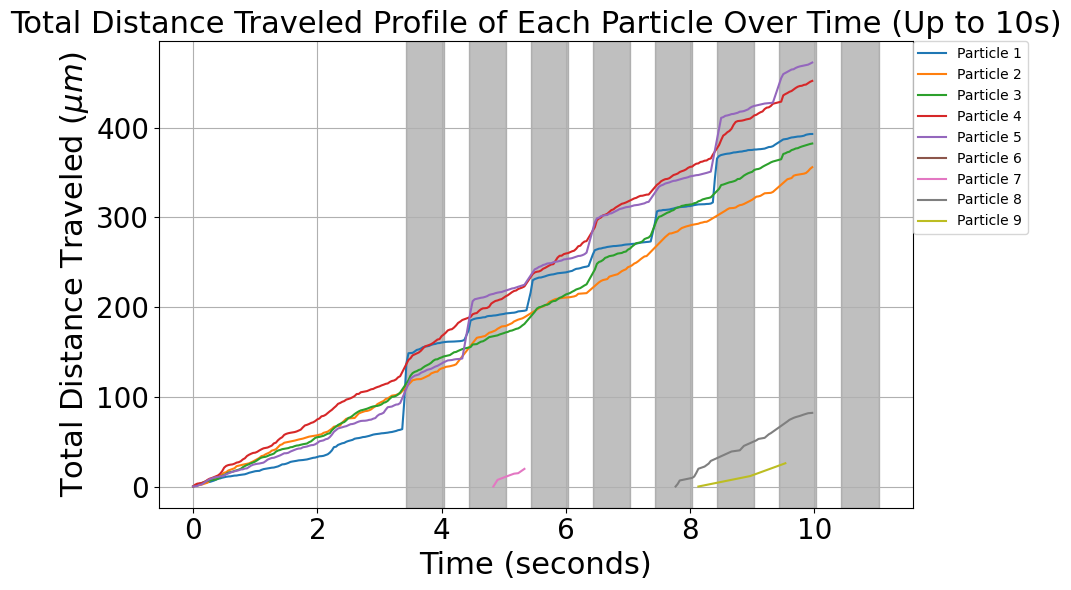

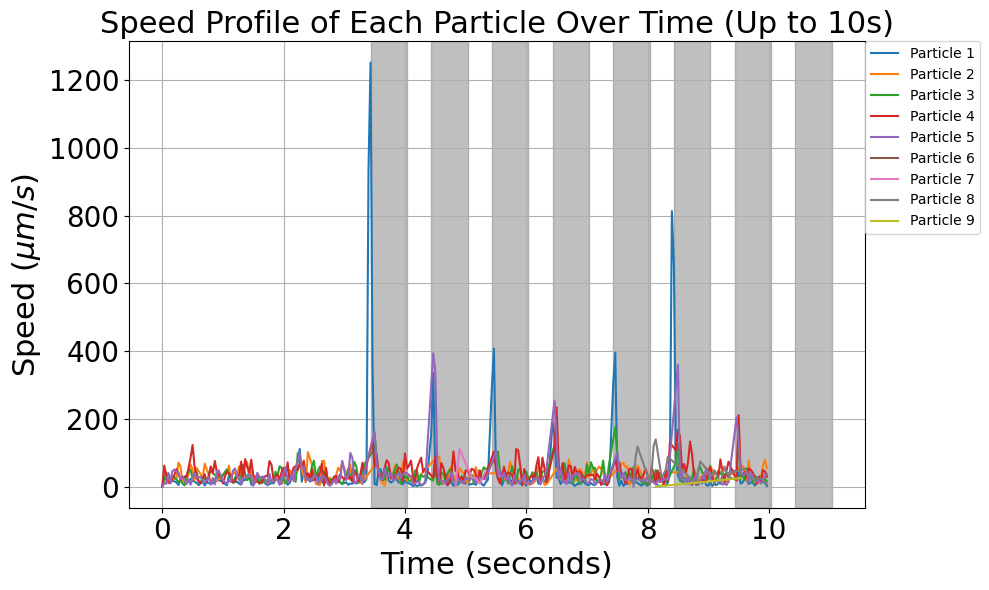

In [485]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming active_traj_filt is already defined and calculated as before
# Define the necessary parameters
frame_rate = 30  # Example frame rate
fps = frame_rate
max_time = 10  # Truncate data up to 10 seconds

# Calculate the time for each frame
active_traj_filt['time'] = active_traj_filt['frame'] / fps
active_traj_filt = active_traj_filt[active_traj_filt['time'] <= max_time]

# Calculate the displacement and total distance traveled
active_traj_filt['dx'] = active_traj_filt.groupby('particle')['x'].diff().fillna(0)
active_traj_filt['dy'] = active_traj_filt.groupby('particle')['y'].diff().fillna(0)
active_traj_filt['displacement'] = np.sqrt(active_traj_filt['dx']**2 + active_traj_filt['dy']**2)

# Calculate the total distance traveled for each particle
active_traj_filt['total_distance_traveled'] = active_traj_filt.groupby('particle')['displacement'].cumsum()

# Calculate the time interval for each frame
active_traj_filt['time_interval'] = active_traj_filt.groupby('particle')['time'].diff().fillna(1/fps)

# Calculate the speed for each particle
active_traj_filt['speed'] = active_traj_filt['displacement'] / active_traj_filt['time_interval']

# Replace inf values with 0 in speed using assign method to avoid the warning
active_traj_filt = active_traj_filt.assign(speed=active_traj_filt['speed'].replace([np.inf, -np.inf], 0))

# Plotting the total distance traveled with ultrasound burst lines for the truncated data
fig1, ax1 = plt.subplots(figsize=(10, 6))
for particle in active_traj_filt['particle'].unique():
    particle_data = active_traj_filt[active_traj_filt['particle'] == particle]
    ax1.plot(particle_data['time'], particle_data['total_distance_traveled'], label=f'Particle {particle}')

# Add vertical shaded areas for ultrasound bursts
ultrasound_burst_frame_increment = 10  # Replace with the value to add to the existing UltrasoundBurstFrame value
hifu_burst_frame_average = active_traj_filt['ultrasound_burst_frame'].mean() + ultrasound_burst_frame_increment
hifu_burst_start = (hifu_burst_frame_average / frame_rate)

for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
    ax1.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)

# Set labels, title, and adjust font sizes
plot_font_size = 22
tick_font_size = 20
ax1.set_xlabel('Time (seconds)', fontsize=plot_font_size)
ax1.set_ylabel(r'Total Distance Traveled ($\mu m$)', fontsize=plot_font_size)
ax1.set_title(f'Total Distance Traveled Profile of Each Particle Over Time (Up to {max_time}s)', fontsize=plot_font_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax1.grid(True)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

# Close the figure to free up memory
plt.close(fig1)

# Plotting the instantaneous velocities with ultrasound burst lines for the truncated data
fig2, ax2 = plt.subplots(figsize=(10, 6))
for particle in active_traj_filt['particle'].unique():
    particle_data = active_traj_filt[active_traj_filt['particle'] == particle]
    ax2.plot(particle_data['time'], particle_data['speed'], label=f'Particle {particle}')

# Add vertical shaded areas for ultrasound bursts
for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
    ax2.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)

# Set labels, title, and adjust font sizes
ax2.set_xlabel('Time (seconds)', fontsize=plot_font_size)
ax2.set_ylabel('Speed ($\mu m/s$)', fontsize=plot_font_size)
ax2.set_title(f'Speed Profile of Each Particle Over Time (Up to {max_time}s)', fontsize=plot_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax2.grid(True)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

# Close the figure to free up memory
plt.close(fig2)


In [486]:
# Remove trajectories from active_traj_filt

def delete_particles_rows(df, particle_numbers):
    """
    Deletes rows from the DataFrame based on a list of particle numbers.
    
    Parameters:
    - df: The DataFrame from which to delete rows.
    - particle_numbers: A list or array of particle numbers whose rows should be deleted.
    """
    # Find indices of rows where the 'particle' column matches any of the specified particle numbers
    indices_to_delete = df[df['particle'].isin(particle_numbers)].index
    
    # Drop these rows from the DataFrame
    df.drop(indices_to_delete, inplace=True)

# Example usage:
particle_numbers_to_delete = []  # Specify the particle numbers you want to delete as a list

# Assuming active_traj_filt is your DataFrame
delete_particles_rows(active_traj_filt, particle_numbers_to_delete)

#Re-plot
#plot_trajectories(active_traj_filt, microns_per_pixel, line_width)

#plot_trajectories(active_traj_filt, microns_per_pixel, line_width, axis_label_size, tick_label_size, save_path)

### Calculate relevant metrics

In [487]:
import numpy as np
import pandas as pd

frame_rate = 30

def calculate_instantaneous_speed(df):
    if len(df) < 2:
        return np.array([0])  # Return single zero for dataframes with less than 2 rows
    dx = np.diff(df['x'])
    dy = np.diff(df['y'])
    distances = np.sqrt(dx**2 + dy**2)
    dt = np.diff(df['time'])
    instantaneous_speeds = distances / dt
    return np.insert(instantaneous_speeds, 0, 0)

def calculate_total_distance_traveled(df):
    if len(df) < 2:
        return np.array([0])  # Return single zero for dataframes with less than 2 rows
    dx = np.diff(df['x'])
    dy = np.diff(df['y'])
    distances = np.sqrt(dx**2 + dy**2)
    total_distance = np.cumsum(distances)
    return np.insert(total_distance, 0, 0)

def calculate_ema(data, window_size=5):
    if len(data) == 0:
        return np.array([])  # Return empty array for empty input
    alpha = 2 / (window_size + 1)
    ema = [data.iloc[0]]  # Use .iloc[0] instead of [0] for pandas Series
    for value in data.iloc[1:]:
        ema_value = alpha * value + (1 - alpha) * ema[-1]
        ema.append(ema_value)
    return np.array(ema)

def calculate_wma(data, window_size=5):
    if len(data) < window_size:
        return np.full(len(data), np.nan)  # Return array of NaNs if not enough data
    weights = np.arange(1, window_size + 1)[::-1]
    wma = np.convolve(data, weights, mode='valid') / weights.sum()
    return np.pad(wma, (window_size - 1, 0), mode='constant', constant_values=np.nan)

def apply_expanding_metrics(df):
    if df.empty:
        return pd.DataFrame()  # Return empty DataFrame if input is empty
    
    df['speed'] = calculate_instantaneous_speed(df)
    df['total_distance_traveled'] = calculate_total_distance_traveled(df)
    
    df['ema_speed'] = calculate_ema(df['speed'])
    df['ema_total_distance'] = calculate_ema(df['total_distance_traveled'])
    
    df['wma_speed'] = calculate_wma(df['speed'])
    df['wma_total_distance'] = calculate_wma(df['total_distance_traveled'])
    
    return df

# Assuming active_traj_filt is your DataFrame
active_traj_filt.reset_index(drop=True, inplace=True)
metrics_df = active_traj_filt.groupby('particle', group_keys=False).apply(apply_expanding_metrics).reset_index(drop=True)



C:\Users\Talaial Alina\AppData\Local\Temp\ipykernel_13352\1758961422.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = active_traj_filt.groupby('particle', group_keys=False).apply(apply_expanding_metrics).reset_index(drop=True)


### Plot relevant metrics

In [488]:
# from ipywidgets import FloatSlider, IntSlider, Output, VBox, HBox, Button
# from IPython.display import display, clear_output, HTML
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
# import pandas as pd
# import numpy as np

# # Constants
# v_f = 0

# # Determine the global min and max for time and velocity
# global_time_min = metrics_df['time'].min()
# global_time_max = metrics_df['time'].max()
# global_velocity_min = min(metrics_df['speed'].min(), metrics_df['avg_speed_10'].min())
# global_velocity_max = max(metrics_df['speed'].max(), metrics_df['avg_speed_10'].max())
# global_total_dist_min = min(metrics_df['total_distance_traveled'].min(), metrics_df['avg_total_distance_traveled_10'].min())
# global_total_dist_max = max(metrics_df['total_distance_traveled'].max(), metrics_df['avg_total_distance_traveled_10'].max())

# # Initialize min_heights_dict for both speed and avg_speed_10
# min_heights_dict = {
#     particle: {
#         'speed': {'value': v_f, 'is_manual': False},
#         'avg_speed_10': {'value': v_f, 'is_manual': False},
#         'avg_total_distance_traveled_10': {'value': v_f, 'is_manual': False}
#     } for particle in metrics_df['particle'].unique()
# }

# plot_output = Output()

# # Initialize DataFrames to store peaks information
# original_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak Speed (µm/s)', 'Peak Displacement Difference (µm)'])
# avg_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak Avg Speed (µm/s)', 'Peak Avg Displacement Difference (µm)'])
# avg_total_dist_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak Avg Total Distance Traveled (µm)', 'Peak Avg Displacement Difference (µm)'])

# # Define the metrics dictionary
# metrics = {
#     'speed': {
#         'data': 'speed',
#         'ylabel': 'Speed ($\\mu m/s$)',
#         'ylim': (global_velocity_min, global_velocity_max),
#         'color': 'blue',
#         'overlay': ['ema_speed', 'wma_speed']
#     },
#     'total_distance_traveled': {
#         'data': 'total_distance_traveled',
#         'ylabel': 'Total Distance Traveled ($\\mu m$)',
#         'ylim': (global_total_dist_min, global_total_dist_max),
#         'color': 'green',
#         'overlay': ['ema_total_distance', 'wma_total_distance']
#     },
#     'avg_speed_10': {
#         'data': 'avg_speed_10',
#         'ylabel': 'Avg Speed (10 neighbors) ($\\mu m/s$)',
#         'ylim': (global_velocity_min, global_velocity_max),
#         'color': 'red'
#     },
#     'avg_total_distance_traveled_10': {
#         'data': 'avg_total_distance_traveled_10',
#         'ylabel': 'Avg Total Distance Traveled (10 neighbors) ($\\mu m$)',
#         'ylim': (global_total_dist_min, global_total_dist_max),
#         'color': 'purple'
#     }
# }



# def get_filtered_peaks(particle_data, metric, min_height):
#     peaks, properties = find_peaks(particle_data[metric], height=min_height)
#     peak_times = particle_data['time'].iloc[peaks].values
#     peak_values = properties['peak_heights']
    
#     max_peaks = []
#     for interval in np.arange(hifu_burst_start, global_time_max, 1):
#         interval_indices = [i for i, t in enumerate(peak_times) if interval - 0.3 <= t <= interval + 0.3]
#         if interval_indices:
#             max_peak_index = interval_indices[np.argmax(peak_values[interval_indices])]
#             max_peaks.append(peaks[max_peak_index])
#     return max_peaks

# def store_and_filter_peaks(particle_data, particle_number, min_heights):
#     original_peaks = get_filtered_peaks(particle_data, 'speed', min_heights['speed'])
#     avg_peaks = get_filtered_peaks(particle_data, 'avg_speed_10', min_heights['avg_speed_10'])
#     avg_total_dist_peaks = get_filtered_peaks(particle_data, 'avg_total_distance_traveled_10', min_heights['avg_total_distance_traveled_10'])
    
#     original_peaks_data = []
#     avg_peaks_data = []
#     avg_total_dist_peaks_data = []

#     for peak_index in original_peaks:
#         time = particle_data['time'].iloc[peak_index]
#         speed = particle_data['speed'].iloc[peak_index]
#         if peak_index == 0:
#             displacement_difference = 0
#         else:
#             current_displacement = particle_data['total_distance_traveled'].iloc[peak_index]
#             prev_displacement = particle_data['total_distance_traveled'].iloc[peak_index - 1]
#             displacement_difference = current_displacement - prev_displacement
#         original_peaks_data.append({
#             'Particle Number': particle_number,
#             'Time (s)': time,
#             'Peak Speed (µm/s)': speed,
#             'Peak Displacement Difference (µm)': displacement_difference
#         })

#     for peak_index in avg_peaks:
#         time = particle_data['time'].iloc[peak_index]
#         avg_speed = particle_data['avg_speed_10'].iloc[peak_index]
#         if peak_index == 0:
#             displacement_difference = 0
#         else:
#             current_displacement = particle_data['total_distance_traveled'].iloc[peak_index]
#             prev_displacement = particle_data['total_distance_traveled'].iloc[peak_index - 1]
#             displacement_difference = current_displacement - prev_displacement
#         avg_peaks_data.append({
#             'Particle Number': particle_number,
#             'Time (s)': time,
#             'Peak Avg Speed (µm/s)': avg_speed,
#             'Peak Avg Displacement Difference (µm)': displacement_difference
#         })

#     for peak_index in avg_total_dist_peaks:
#         time = particle_data['time'].iloc[peak_index]
#         avg_total_dist = particle_data['avg_total_distance_traveled_10'].iloc[peak_index]
#         if peak_index == 0:
#             displacement_difference = 0
#         else:
#             current_displacement = particle_data['total_distance_traveled'].iloc[peak_index]
#             prev_displacement = particle_data['total_distance_traveled'].iloc[peak_index - 1]
#             displacement_difference = current_displacement - prev_displacement
#         avg_total_dist_peaks_data.append({
#             'Particle Number': particle_number,
#             'Time (s)': time,
#             'Peak Avg Total Distance Traveled (µm)': avg_total_dist,
#             'Peak Avg Displacement Difference (µm)': displacement_difference
#         })

#     return pd.DataFrame(original_peaks_data), pd.DataFrame(avg_peaks_data), pd.DataFrame(avg_total_dist_peaks_data)

# def plot_peaks(ax, particle_data, metric, min_height):
#     max_peaks = get_filtered_peaks(particle_data, metric, min_height)
#     if max_peaks:
#         peak_times = particle_data['time'].iloc[max_peaks].values
#         peak_values = particle_data[metric].iloc[max_peaks].values
#         ax.plot(peak_times, peak_values, "x", color='red', label='Detected Peaks')
        
#         for i, (time, value) in enumerate(zip(peak_times, peak_values)):
#             ax.annotate(f'Peak {i+1}', (time, value), textcoords="offset points", xytext=(0,10), ha='center')
    
#     ax.axhline(y=min_height, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Min Height')
    
#     return max_peaks

# def update_plot(particle_number):
#     global original_peaks_df, avg_peaks_df, avg_total_dist_peaks_df, hifu_burst_start
#     with plot_output:
#         clear_output(wait=True)
#         particle_data = metrics_df[metrics_df['particle'] == particle_number]
        
#         if particle_data.empty:
#             print(f"No data found for particle {particle_number}")
#             return
        
#         min_heights = {
#             'speed': min_heights_dict[particle_number]['speed']['value'],
#             'avg_speed_10': min_heights_dict[particle_number]['avg_speed_10']['value'],
#             'avg_total_distance_traveled_10': min_heights_dict[particle_number]['avg_total_distance_traveled_10']['value']
#         }
        
#         with plt.rc_context({'font.size': 16, 'axes.titlesize': 20, 'axes.labelsize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'legend.fontsize': 16}):
#             num_metrics = len(metrics)
#             fig, axs = plt.subplots(1, num_metrics, figsize=(15*num_metrics, 12), sharex=False)
#             fig.suptitle(f'Metrics for Particle {particle_number}', fontsize=24, y=0.95)

#             if num_metrics == 1:
#                 axs = [axs]

#             speed_peaks = None
#             avg_speed_peaks = None

#             for (metric, properties), ax in zip(metrics.items(), axs):
#                 ax.plot(particle_data['time'], particle_data[properties['data']], label=f'{properties["ylabel"]}', alpha=0.6, color=properties['color'])
#                 ax.scatter(particle_data['time'], particle_data[properties['data']], s=10, color=properties['color'], alpha=0.6)
                
#                 # Plot overlay metrics if they exist
#                 if 'overlay' in properties:
#                     for overlay_metric in properties['overlay']:
#                         if overlay_metric.startswith('ema'):
#                             ax.plot(particle_data['time'], particle_data[overlay_metric], label=f'EMA {properties["ylabel"]}', color='orange', alpha=0.8)
#                         elif overlay_metric.startswith('wma'):
#                             ax.plot(particle_data['time'], particle_data[overlay_metric], label=f'WMA {properties["ylabel"]}', color='purple', alpha=0.8)
                
#                 ax.set_xlabel('Time (s)')
#                 ax.set_ylabel(properties['ylabel'])
#                 ax.set_ylim(properties['ylim'])
#                 ax.set_title(f"{properties['ylabel']} vs. Time for Particle {particle_number}", y=1.05)
#                 ax.grid(True)
                
#                 if metric in ['speed', 'avg_speed_10']:
#                     peaks = plot_peaks(ax, particle_data, properties['data'], min_heights[metric])
#                     if metric == 'speed':
#                         speed_peaks = peaks
#                     else:
#                         avg_speed_peaks = peaks
#                 elif metric in ['total_distance_traveled', 'avg_total_distance_traveled_10']:
#                     if speed_peaks is not None:
#                         times = particle_data['time'].iloc[speed_peaks].values
#                         values = particle_data[properties['data']].iloc[speed_peaks].values
#                         ax.plot(times, values, "x", color='red', label='Corresponding Peaks')
#                         for i, (time, value) in enumerate(zip(times, values)):
#                             ax.annotate(f'Peak {i+1}', (time, value), textcoords="offset points", xytext=(0,10), ha='center')

#                 for interval in np.arange(hifu_burst_start, global_time_max, 1):
#                     ax.axvline(x=interval - 0.3, color='black', linestyle='--', linewidth=1, alpha=0.7)
#                     ax.axvline(x=interval + 0.3, color='black', linestyle='--', linewidth=1, alpha=0.7)
#                     ax.axvspan(interval - 0.3, interval + 0.3, color='lightgray', alpha=0.3)

#                 ax.set_xlim(global_time_min, global_time_max)
#                 ax.legend(loc='best')

#             plt.subplots_adjust(hspace=0.4, wspace=0.2, right=0.95, top=0.85)
#             plt.show()

#         original_peaks, avg_peaks, avg_total_dist_peaks = store_and_filter_peaks(particle_data, particle_number, min_heights)
#         original_peaks_df = pd.concat([original_peaks_df[original_peaks_df['Particle Number'] != particle_number], original_peaks], ignore_index=True)
#         avg_peaks_df = pd.concat([avg_peaks_df[avg_peaks_df['Particle Number'] != particle_number], avg_peaks], ignore_index=True)
#         avg_total_dist_peaks_df = pd.concat([avg_total_dist_peaks_df[avg_total_dist_peaks_df['Particle Number'] != particle_number], avg_total_dist_peaks], ignore_index=True)
        
#         original_peaks_df.sort_values(by=['Particle Number', 'Time (s)'], inplace=True)
#         original_peaks_df.reset_index(drop=True, inplace=True)
        
#         avg_peaks_df.sort_values(by=['Particle Number', 'Time (s)'], inplace=True)
#         avg_peaks_df.reset_index(drop=True, inplace=True)
        
#         avg_total_dist_peaks_df.sort_values(by=['Particle Number', 'Time (s)'], inplace=True)
#         avg_total_dist_peaks_df.reset_index(drop=True, inplace=True)

# # Define sliders
# particle_number_slider = IntSlider(min=min(min_heights_dict.keys()), max=max(min_heights_dict.keys()), step=1, description='Particle Number', value=min(min_heights_dict.keys()))
# speed_min_height_slider = FloatSlider(min=global_velocity_min, max=global_velocity_max, step=0.001, description='Speed Min Height', value=v_f)
# avg_speed_min_height_slider = FloatSlider(min=global_velocity_min, max=global_velocity_max, step=0.001, description='Avg Speed Min Height', value=v_f)
# avg_total_distance_min_height_slider = FloatSlider(min=global_total_dist_min, max=global_total_dist_max, step=0.001, description='Avg Total Dist Min Height', value=v_f)

# # Add a new slider for HIFU burst start
# hifu_burst_start_slider = FloatSlider(min=global_time_min, max=global_time_max, step=0.01, description='HIFU Burst Start', value=hifu_burst_start)

# def on_particle_number_change(change):
#     new_particle_number = change['new']
#     speed_min_height_info = min_heights_dict[new_particle_number]['speed']
#     avg_speed_min_height_info = min_heights_dict[new_particle_number]['avg_speed_10']
#     avg_total_distance_min_height_info = min_heights_dict[new_particle_number]['avg_total_distance_traveled_10']
    
#     global is_programmatic_update
#     is_programmatic_update = True
#     try:
#         speed_min_height_slider.value = speed_min_height_info['value']
#         avg_speed_min_height_slider.value = avg_speed_min_height_info['value']
#         avg_total_distance_min_height_slider.value = avg_total_distance_min_height_info['value']
#     finally:
#         is_programmatic_update = False
    
#     update_plot(new_particle_number)

# def on_min_height_change(change):
#     if not is_programmatic_update:
#         current_particle = particle_number_slider.value
#         new_speed_min_height = speed_min_height_slider.value
#         new_avg_speed_min_height = avg_speed_min_height_slider.value
#         new_avg_total_distance_min_height = avg_total_distance_min_height_slider.value
        
#         min_heights_dict[current_particle]['speed'] = {'value': new_speed_min_height, 'is_manual': True}
#         min_heights_dict[current_particle]['avg_speed_10'] = {'value': new_avg_speed_min_height, 'is_manual': True}
#         min_heights_dict[current_particle]['avg_total_distance_traveled_10'] = {'value': new_avg_total_distance_min_height, 'is_manual': True}
        
#         update_plot(current_particle)

# def on_hifu_burst_start_change(change):
#     global hifu_burst_start
#     hifu_burst_start = change['new']
#     update_plot(particle_number_slider.value)

# particle_number_slider.observe(on_particle_number_change, names='value')
# speed_min_height_slider.observe(on_min_height_change, names='value')
# avg_speed_min_height_slider.observe(on_min_height_change, names='value')
# avg_total_distance_min_height_slider.observe(on_min_height_change, names='value')
# hifu_burst_start_slider.observe(on_hifu_burst_start_change, names='value')

# # Create and display the UI
# plot_output = Output()
# ui = VBox([
#     HBox([particle_number_slider]),
#     HBox([speed_min_height_slider, avg_speed_min_height_slider, avg_total_distance_min_height_slider]),
#     HBox([hifu_burst_start_slider]),  # Add the new slider to the UI
#     plot_output
# ])
# display(ui)

# # Initial plot update
# initial_particle_number = particle_number_slider.value
# update_plot(initial_particle_number)




In [489]:
from ipywidgets import FloatSlider, IntSlider, Output, VBox, HBox, Button
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

# Constants
v_f = 0

# Determine the global min and max for time and velocity
global_time_min = metrics_df['time'].min()
global_time_max = metrics_df['time'].max()
global_velocity_min = min(metrics_df['speed'].min(), metrics_df['ema_speed'].min())
global_velocity_max = max(metrics_df['speed'].max(), metrics_df['ema_speed'].max())
global_total_dist_min = min(metrics_df['total_distance_traveled'].min(), metrics_df['ema_total_distance'].min())
global_total_dist_max = max(metrics_df['total_distance_traveled'].max(), metrics_df['ema_total_distance'].max())

# Initialize min_heights_dict for both speed and ema_speed
# min_heights_dict = {
#     particle: {
#         'speed': {'value': v_f, 'is_manual': False},
#         'ema_speed': {'value': v_f, 'is_manual': False},
#         'ema_total_distance': {'value': v_f, 'is_manual': False},
#         'wma_speed': {'value': v_f, 'is_manual': False},
#         'wma_total_distance': {'value': v_f, 'is_manual': False}
#     } for particle in metrics_df['particle'].unique()
# }

# Initialize min_heights_dict for all metrics
min_heights_dict = {
    particle: {
        'speed': {'value': v_f, 'is_manual': False},
        'ema_speed': {'value': v_f, 'is_manual': False},
        'ema_total_distance': {'value': v_f, 'is_manual': False},
        'wma_speed': {'value': v_f, 'is_manual': False},
        'wma_total_distance': {'value': v_f, 'is_manual': False}
    } for particle in metrics_df['particle'].unique()
}

# Initialize DataFrames to store peaks information
# Initialize DataFrames to store peaks information
original_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak Speed (µm/s)', 'Peak Displacement Difference (µm)'])
ema_speed_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak Speed (µm/s)', 'Peak Displacement Difference (µm)'])
ema_total_dist_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak EMA Total Distance (µm)', 'Peak EMA Displacement Difference (µm)'])
wma_speed_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak Speed (µm/s)', 'Peak Displacement Difference (µm)'])
wma_total_dist_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak WMA Total Distance (µm)', 'Peak WMA Displacement Difference (µm)'])
total_dist_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Peak Total Distance Traveled (µm)', 'Peak Displacement Difference (µm)'])

# Define the metrics dictionary
# Update the metrics dictionary to include WMA
metrics = {
    'speed': {
        'data': 'speed',
        'ylabel': 'Speed ($\\mu m/s$)',
        'ylim': (global_velocity_min, global_velocity_max),
        'color': 'blue'
    },
    'total_distance_traveled': {
        'data': 'total_distance_traveled',
        'ylabel': 'Total Distance Traveled ($\\mu m$)',
        'ylim': (global_total_dist_min, global_total_dist_max),
        'color': 'green'
    },
    'ema_speed': {
        'data': 'ema_speed',
        'ylabel': 'EMA Speed ($\\mu m/s$)',
        'ylim': (global_velocity_min, global_velocity_max),
        'color': 'red'
    },
    'ema_total_distance': {
        'data': 'ema_total_distance',
        'ylabel': 'EMA Total Distance ($\\mu m$)',
        'ylim': (global_total_dist_min, global_total_dist_max),
        'color': 'purple'
    },
    'wma_speed': {
        'data': 'wma_speed',
        'ylabel': 'WMA Speed ($\\mu m/s$)',
        'ylim': (global_velocity_min, global_velocity_max),
        'color': 'orange'
    },
    'wma_total_distance': {
        'data': 'wma_total_distance',
        'ylabel': 'WMA Total Distance ($\\mu m$)',
        'ylim': (global_total_dist_min, global_total_dist_max),
        'color': 'brown'
    }
}


def get_filtered_peaks(particle_data, metric, min_height):
    peaks, properties = find_peaks(particle_data[metric], height=min_height)
    peak_times = particle_data['time'].iloc[peaks].values
    peak_values = properties['peak_heights']
    
    max_peaks = []
    for interval in np.arange(hifu_burst_start, global_time_max, 1):
        interval_indices = [i for i, t in enumerate(peak_times) if interval - 0.3 <= t <= interval + 0.3]
        if interval_indices:
            max_peak_index = interval_indices[np.argmax(peak_values[interval_indices])]
            max_peaks.append(peaks[max_peak_index])
    return max_peaks

# Update the store_and_filter_peaks function
def store_and_filter_peaks(particle_data, particle_number, min_heights):
    def process_peaks(peaks, metric):
        peaks_data = []
        for peak_index in peaks:
            time = particle_data['time'].iloc[peak_index]
            value = particle_data[metric].iloc[peak_index]
            if peak_index == 0:
                displacement_difference = 0
            else:
                current_displacement = particle_data['total_distance_traveled'].iloc[peak_index]
                prev_displacement = particle_data['total_distance_traveled'].iloc[peak_index - 1]
                displacement_difference = current_displacement - prev_displacement
            
            # Use a dynamic column name based on the metric
            if metric == 'speed':
                peak_column_name = 'Peak Speed (µm/s)'
            elif metric == 'ema_speed':
                peak_column_name = 'Peak Speed (µm/s)'
            elif metric == 'wma_speed':
                peak_column_name = 'Peak Speed (µm/s)'
            else:
                peak_column_name = f'Peak {metric.replace("_", " ").title()} (µm/s)'
            
            peaks_data.append({
                'Particle Number': particle_number,
                'Time (s)': time,
                peak_column_name: value,
                'Peak Displacement Difference (µm)': displacement_difference
            })
        return pd.DataFrame(peaks_data)

    original_peaks = get_filtered_peaks(particle_data, 'speed', min_heights['speed'])
    ema_speed_peaks = get_filtered_peaks(particle_data, 'ema_speed', min_heights['ema_speed'])
    wma_speed_peaks = get_filtered_peaks(particle_data, 'wma_speed', min_heights['wma_speed'])

    original_peaks_df = process_peaks(original_peaks, 'speed')
    ema_speed_peaks_df = process_peaks(ema_speed_peaks, 'ema_speed')
    wma_speed_peaks_df = process_peaks(wma_speed_peaks, 'wma_speed')

    return original_peaks_df, ema_speed_peaks_df, wma_speed_peaks_df

def plot_peaks(ax, particle_data, metric, min_height):
    max_peaks = get_filtered_peaks(particle_data, metric, min_height)
    if max_peaks:
        peak_times = particle_data['time'].iloc[max_peaks].values
        peak_values = particle_data[metric].iloc[max_peaks].values
        ax.plot(peak_times, peak_values, "x", color='red', label='Detected Peaks')
        
        for i, (time, value) in enumerate(zip(peak_times, peak_values)):
            ax.annotate(f'Peak {i+1}', (time, value), textcoords="offset points", xytext=(0,10), ha='center')
    
    ax.axhline(y=min_height, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Min Height')
    
    return max_peaks

# Updated update_plot function
def update_plot(particle_number):
    global original_peaks_df, ema_speed_peaks_df, wma_speed_peaks_df, hifu_burst_start
    
    with plot_output:
        clear_output(wait=True)
        particle_data = metrics_df[metrics_df['particle'] == particle_number]
        
        if particle_data.empty:
            print(f"No data found for particle {particle_number}")
            return
        
        min_heights = {
            'speed': min_heights_dict[particle_number]['speed']['value'],
            'ema_speed': min_heights_dict[particle_number]['ema_speed']['value'],
            'ema_total_distance': min_heights_dict[particle_number]['ema_total_distance']['value'],
            'wma_speed': min_heights_dict[particle_number]['wma_speed']['value'],
            'wma_total_distance': min_heights_dict[particle_number]['wma_total_distance']['value'],
            'total_distance_traveled': min_heights_dict[particle_number]['speed']['value']
        }
        
        with plt.rc_context({'font.size': 10, 'axes.titlesize': 12, 'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 8}):
            fig, axs = plt.subplots(3, 2, figsize=(20, 15))
            fig.suptitle(f'Metrics for Particle {particle_number}', fontsize=16, y=0.98)

            for i, (metric_name, metric_info) in enumerate(metrics.items()):
                ax = axs[i // 2, i % 2]
                ax.plot(particle_data['time'], particle_data[metric_info['data']], label=metric_name.replace('_', ' ').title(), alpha=0.8, color=metric_info['color'])
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(metric_info['ylabel'])
                ax.set_ylim(metric_info['ylim'])
                ax.set_title(f"{metric_name.replace('_', ' ').title()} vs. Time", y=1.02)
                ax.grid(True, linestyle='--', alpha=0.7)
                
                if 'speed' in metric_name or metric_name in ['ema_speed', 'wma_speed']:
                    plot_peaks(ax, particle_data, metric_info['data'], min_heights[metric_name])
                elif 'total_distance' in metric_name or metric_name == 'total_distance_traveled':
                    corresponding_speed = 'speed' if metric_name == 'total_distance_traveled' else metric_name.replace('total_distance', 'speed')
                    if corresponding_speed in min_heights:
                        speed_peaks = get_filtered_peaks(particle_data, corresponding_speed, min_heights[corresponding_speed])
                        if speed_peaks is not None:
                            times = particle_data['time'].iloc[speed_peaks].values
                            values = particle_data[metric_info['data']].iloc[speed_peaks].values
                            ax.plot(times, values, "x", color='red', label='Corresponding Peaks')
                            for j, (time, value) in enumerate(zip(times, values)):
                                ax.annotate(f'Peak {j+1}', (time, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

                for interval in np.arange(hifu_burst_start, global_time_max, 1):
                    ax.axvline(x=interval - 0.3, color='black', linestyle='--', linewidth=0.5, alpha=0.7)
                    ax.axvline(x=interval + 0.3, color='black', linestyle='--', linewidth=0.5, alpha=0.7)
                    ax.axvspan(interval - 0.3, interval + 0.3, color='lightgray', alpha=0.3)

                ax.set_xlim(global_time_min, global_time_max)
                ax.legend(loc='best')

            plt.tight_layout()
            plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)
            plt.show()

        new_original_peaks, new_ema_speed_peaks, new_wma_speed_peaks = store_and_filter_peaks(particle_data, particle_number, min_heights)
        
        # Update global DataFrames
        original_peaks_df = pd.concat([original_peaks_df[original_peaks_df['Particle Number'] != particle_number], new_original_peaks], ignore_index=True)
        ema_speed_peaks_df = pd.concat([ema_speed_peaks_df[ema_speed_peaks_df['Particle Number'] != particle_number], new_ema_speed_peaks], ignore_index=True)
        wma_speed_peaks_df = pd.concat([wma_speed_peaks_df[wma_speed_peaks_df['Particle Number'] != particle_number], new_wma_speed_peaks], ignore_index=True)
        
        for df in [original_peaks_df, ema_speed_peaks_df, wma_speed_peaks_df]:
            df.sort_values(by=['Particle Number', 'Time (s)'], inplace=True)
            df.reset_index(drop=True, inplace=True)

# Define sliders
particle_number_slider = IntSlider(min=min(min_heights_dict.keys()), max=max(min_heights_dict.keys()), step=1, description='Particle Number', value=min(min_heights_dict.keys()))
speed_min_height_slider = FloatSlider(min=global_velocity_min, max=global_velocity_max, step=0.001, description='Speed Min Height', value=v_f)
ema_speed_min_height_slider = FloatSlider(min=global_velocity_min, max=global_velocity_max, step=0.001, description='EMA Speed Min Height', value=v_f)
ema_total_distance_min_height_slider = FloatSlider(min=global_total_dist_min, max=global_total_dist_max, step=0.001, description='EMA Total Dist Min Height', value=v_f)
wma_speed_min_height_slider = FloatSlider(min=global_velocity_min, max=global_velocity_max, step=0.001, description='WMA Speed Min Height', value=v_f)
wma_total_distance_min_height_slider = FloatSlider(min=global_total_dist_min, max=global_total_dist_max, step=0.001, description='WMA Total Dist Min Height', value=v_f)

# Add a new slider for HIFU burst start
hifu_burst_start_slider = FloatSlider(min=global_time_min, max=global_time_max, step=0.01, description='HIFU Burst Start', value=hifu_burst_start)

def on_particle_number_change(change):
    new_particle_number = change['new']
    speed_min_height_info = min_heights_dict[new_particle_number]['speed']
    ema_speed_min_height_info = min_heights_dict[new_particle_number]['ema_speed']
    ema_total_distance_min_height_info = min_heights_dict[new_particle_number]['ema_total_distance']
    
    global is_programmatic_update
    is_programmatic_update = True
    try:
        speed_min_height_slider.value = speed_min_height_info['value']
        ema_speed_min_height_slider.value = ema_speed_min_height_info['value']
        ema_total_distance_min_height_slider.value = ema_total_distance_min_height_info['value']
    finally:
        is_programmatic_update = False
    
    update_plot(new_particle_number)

# Update the on_min_height_change function
# Updated on_min_height_change function
def on_min_height_change(change):
    if not is_programmatic_update:
        current_particle = particle_number_slider.value
        new_speed_min_height = speed_min_height_slider.value
        new_ema_speed_min_height = ema_speed_min_height_slider.value
        new_ema_total_distance_min_height = ema_total_distance_min_height_slider.value
        new_wma_speed_min_height = wma_speed_min_height_slider.value
        new_wma_total_distance_min_height = wma_total_distance_min_height_slider.value
        
        min_heights_dict[current_particle]['speed'] = {'value': new_speed_min_height, 'is_manual': True}
        min_heights_dict[current_particle]['ema_speed'] = {'value': new_ema_speed_min_height, 'is_manual': True}
        min_heights_dict[current_particle]['ema_total_distance'] = {'value': new_ema_total_distance_min_height, 'is_manual': True}
        min_heights_dict[current_particle]['wma_speed'] = {'value': new_wma_speed_min_height, 'is_manual': True}
        min_heights_dict[current_particle]['wma_total_distance'] = {'value': new_wma_total_distance_min_height, 'is_manual': True}
        
        update_plot(current_particle)

def on_hifu_burst_start_change(change):
    global hifu_burst_start
    hifu_burst_start = change['new']
    update_plot(particle_number_slider.value)

particle_number_slider.observe(on_particle_number_change, names='value')
speed_min_height_slider.observe(on_min_height_change, names='value')
ema_speed_min_height_slider.observe(on_min_height_change, names='value')
ema_total_distance_min_height_slider.observe(on_min_height_change, names='value')
hifu_burst_start_slider.observe(on_hifu_burst_start_change, names='value')
wma_speed_min_height_slider.observe(on_min_height_change, names='value')
wma_total_distance_min_height_slider.observe(on_min_height_change, names='value')

# Create and display the UI
plot_output = Output()
# Updated UI
ui = VBox([
    HBox([particle_number_slider]),
    HBox([speed_min_height_slider, ema_speed_min_height_slider, ema_total_distance_min_height_slider]),
    HBox([wma_speed_min_height_slider, wma_total_distance_min_height_slider]),
    HBox([hifu_burst_start_slider]),
    plot_output
])
display(ui)

# Initial plot update
initial_particle_number = particle_number_slider.value
update_plot(initial_particle_number)

In [490]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Lists to store particle numbers of deleted rows
deleted_particle_numbers = {
    'original': [],
    'ema_speed': [],
    'wma_speed': []
}

# Function to delete row from the original peaks DataFrame
def delete_original_row(index):
    global deleted_original_particle_numbers
    deleted_particle_number = original_peaks_df.loc[index, 'Particle Number']
    deleted_original_particle_numbers.append(deleted_particle_number)
    original_peaks_df.drop(index, inplace=True)
    display_dataframe(original_peaks_df, avg_peaks_df)

# Function to delete row from the average peaks DataFrame
def delete_avg_row(index):
    global deleted_avg_particle_numbers
    deleted_particle_number = avg_peaks_df.loc[index, 'Particle Number']
    deleted_avg_particle_numbers.append(deleted_particle_number)
    avg_peaks_df.drop(index, inplace=True)
    display_dataframe(original_peaks_df, avg_peaks_df)

# Function to handle button click event for original peaks
def on_original_button_click(b):
    index = int(b.tooltip)
    delete_original_row(index)
    b.style.button_color = 'red'
    print(f"Deleted particle number from original peaks: {deleted_original_particle_numbers[-1]}")

# Function to handle button click event for average peaks
def on_avg_button_click(b):
    index = int(b.tooltip)
    delete_avg_row(index)
    b.style.button_color = 'red'
    print(f"Deleted particle number from avg peaks: {deleted_avg_particle_numbers[-1]}")

# Function to display the DataFrames
def display_dataframe(original_df, avg_df):
    output = widgets.Output()
    with output:
        output.clear_output()

        # Create larger buttons for original peaks DataFrame
        original_buttons = [widgets.Button(description="X", tooltip=str(idx), layout=widgets.Layout(width='40px', height='40px')) for idx, _ in original_df.iterrows()]
        for button in original_buttons:
            button.on_click(on_original_button_click)

        # Create larger buttons for average peaks DataFrame
        avg_buttons = [widgets.Button(description="X", tooltip=str(idx), layout=widgets.Layout(width='40px', height='40px')) for idx, _ in avg_df.iterrows()]
        for button in avg_buttons:
            button.on_click(on_avg_button_click)

        # Display the DataFrames with buttons
        original_data_widget = widgets.HTML(value=original_df.to_html(classes="table table-striped"))
        original_button_widget = widgets.VBox(original_buttons, layout=widgets.Layout(align_items='center', justify_content='center'))
        
        avg_data_widget = widgets.HTML(value=avg_df.to_html(classes="table table-striped"))
        avg_button_widget = widgets.VBox(avg_buttons, layout=widgets.Layout(align_items='center', justify_content='center'))
        
        display(widgets.VBox([
            widgets.HTML("<h3>Original Peaks</h3>"),
            widgets.HBox([original_data_widget, original_button_widget]),
            widgets.HTML("<h3>Avg Peaks</h3>"),
            widgets.HBox([avg_data_widget, avg_button_widget])
        ]))
    display(output)

# Initial display
display_dataframes()

Output()

In [491]:
# Define the lists of particle numbers to delete
deleted_particle_numbers = {
    'original': [],
    'ema_speed': [],
    'wma_speed': []
}

# Function to delete rows from a DataFrame based on particle numbers
def delete_rows(df, particle_numbers):
    return df[~df['Particle Number'].isin(particle_numbers)]

# Delete rows from each DataFrame based on the corresponding deleted_particle_numbers
original_peaks_df = delete_rows(original_peaks_df, deleted_particle_numbers['original'])
ema_speed_peaks_df = delete_rows(ema_speed_peaks_df, deleted_particle_numbers['ema_speed'])
wma_speed_peaks_df = delete_rows(wma_speed_peaks_df, deleted_particle_numbers['wma_speed'])

### Now, velocity_stats DataFrame contains the average velocity and standard deviation at each time point.

In [492]:
import numpy as np
import pandas as pd

def population_std(x):
    return np.std(x, ddof=0)

def aggregate_velocity_stats(df, speed_col, displacement_col):
    return df.groupby('Time (s)').agg(
        particle_count=('Particle Number', 'nunique'),
        average_velocity=(speed_col, 'mean'),
        velocity_std_dev=(speed_col, population_std),
        average_displacement=(displacement_col, 'mean'),
        displacement_std_dev=(displacement_col, population_std)
    ).reset_index()

# Define the DataFrames and their corresponding prefixes
df_info = {
    'original': {'df': original_peaks_df, 'prefix': '', 'variable_name': 'original_velocity_stats'},
    'ema': {'df': ema_speed_peaks_df, 'prefix': 'EMA ', 'variable_name': 'ema_velocity_stats'},
    'wma': {'df': wma_speed_peaks_df, 'prefix': 'WMA ', 'variable_name': 'wma_velocity_stats'}
}

# Process each DataFrame and store the results in global variables
for key, info in df_info.items():
    # Aggregate stats
    stats = aggregate_velocity_stats(info['df'], 'Peak Speed (µm/s)', 'Peak Displacement Difference (µm)')
    
    # Rename columns
    new_columns = {
        'particle_count': 'Particle Count',
        'average_velocity': f'Average Peak Speed (µm/s)',
        'velocity_std_dev': f'Peak Speed Std Dev (µm/s)',
        'average_displacement': f'Average Displacement Difference (µm)',
        'displacement_std_dev': f'Displacement Difference Std Dev (µm)'
    }
    stats.rename(columns=new_columns, inplace=True)
    
    # Define column order
    column_order = ['Time (s)', 'Particle Count'] + list(new_columns.values())[1:]
    
    # Reorder columns
    stats = stats[column_order]
    
    # Store the result in a global variable
    globals()[info['variable_name']] = stats

# Optionally, display the results
for key, info in df_info.items():
    print(f"\n{key.capitalize()} Velocity Stats:")
    display(globals()[info['variable_name']])



Original Velocity Stats:


,Time (s),Particle Count,Average Peak Speed (µm/s),Peak Speed Std Dev (µm/s),Average Displacement Difference (µm),Displacement Difference Std Dev (µm)
0,3.433333,1,1252.103756,0.000000,41.736792,0.000000
1,3.466667,1,136.107045,0.000000,18.147606,0.000000
2,3.500000,2,158.981552,2.791267,16.084240,10.877897
3,3.966667,1,73.660341,0.000000,2.455345,0.000000
4,4.466667,2,364.408212,28.983014,31.816502,20.635662
5,4.500000,1,85.177317,0.000000,2.839244,0.000000
6,4.533333,1,88.705885,0.000000,26.611766,0.000000
7,4.800000,1,103.783045,0.000000,3.459435,0.000000
8,4.900000,1,110.849883,0.000000,7.389992,0.000000
9,5.466667,1,407.095780,0.000000,13.569859,0.000000



Ema Velocity Stats:


,Time (s),Particle Count,Average Peak Speed (µm/s),Peak Speed Std Dev (µm/s),Average Displacement Difference (µm),Displacement Difference Std Dev (µm)
0,3.433333,1,634.669173,0.000000,41.736792,0.000000
1,3.500000,2,85.196791,10.353764,16.084240,10.877897
2,3.533333,2,60.075645,16.747364,8.866328,5.720927
3,4.466667,1,152.739116,0.000000,11.180840,0.000000
4,4.500000,3,103.997604,72.491039,5.729102,3.984043
5,4.566667,1,59.883464,0.000000,2.908802,0.000000
6,4.900000,1,36.949961,0.000000,7.389992,0.000000
7,5.466667,1,207.424940,0.000000,13.569859,0.000000
8,5.500000,1,48.846809,0.000000,17.267107,0.000000
9,5.533333,1,71.299166,0.000000,3.453528,0.000000



Wma Velocity Stats:


,Time (s),Particle Count,Average Peak Speed (µm/s),Peak Speed Std Dev (µm/s),Average Displacement Difference (µm),Displacement Difference Std Dev (µm)
0,3.433333,1,676.349222,0.000000,41.736792,0.000000
1,3.533333,4,75.473001,22.196100,5.640519,5.181335
2,4.466667,1,160.982526,0.000000,11.180840,0.000000
3,4.500000,3,108.889825,80.539671,5.729102,3.984043
4,4.566667,1,61.700400,0.000000,2.908802,0.000000
5,5.466667,1,220.345114,0.000000,13.569859,0.000000
6,5.533333,1,76.626501,0.000000,3.453528,0.000000
7,5.566667,1,48.993311,0.000000,1.559933,0.000000
8,5.733333,1,48.351174,0.000000,2.452418,0.000000
9,5.900000,1,74.991734,0.000000,2.065813,0.000000


In [493]:
# Define the types of analysis
analysis_types = ['original', 'ema', 'wma']

# Ensure all analysis types have an entry in deleted_particle_numbers
for analysis_type in analysis_types:
    if analysis_type not in deleted_particle_numbers:
        deleted_particle_numbers[analysis_type] = []

# Create a dictionary to store the filtered DataFrames
filtered_metrics = {}

# Filter the metrics_df for each analysis type
for analysis_type in analysis_types:
    deleted_particles = deleted_particle_numbers[analysis_type]
    filtered_metrics[analysis_type] = metrics_df[~metrics_df['particle'].isin(deleted_particles)]

# Now you can access the filtered DataFrames like this:
filtered_active_traj_filt_original = filtered_metrics['original']
filtered_active_traj_filt_ema = filtered_metrics['ema']
filtered_active_traj_filt_wma = filtered_metrics['wma']

In [494]:
# Function to keep only common particles
def keep_only_common_particles(active_df, peaks_df):
    """
    Keeps rows in active_df only if their 'particle' value exists in the 'Particle Number' column of peaks_df.
    
    Parameters:
    - active_df: DataFrame with a 'particle' column, representing the dataset to filter.
    - peaks_df: DataFrame with a 'Particle Number' column, representing the reference dataset.
    """
    valid_particle_numbers = peaks_df['Particle Number'].unique()
    mask = active_df['particle'].isin(valid_particle_numbers)
    filtered_df = active_df[mask]
    return filtered_df

# Define the types of analysis and corresponding peaks DataFrames
analysis_types = {
    'original': original_peaks_df,
    'ema': ema_speed_peaks_df,
    'wma': wma_speed_peaks_df
}

# Apply the function to each filtered DataFrame
for analysis_type, peaks_df in analysis_types.items():
    filtered_metrics[analysis_type] = keep_only_common_particles(filtered_metrics[analysis_type], peaks_df)

# Now you can access the updated filtered DataFrames like this:
filtered_active_traj_filt_original = filtered_metrics['original']
filtered_active_traj_filt_ema = filtered_metrics['ema']
filtered_active_traj_filt_wma = filtered_metrics['wma']

Original processing complete.
Filtered XML file created at: E:/Particle tracking/Summer Semester Jun-Aug 2024/04AUG24-2\Compilation\xml_updated\Original xmls\MSN - 450 mVpp - 1_original_filtered.xml
Original Total Distance Traveled and Speed file saved at: E:\Particle tracking\Summer Semester Jun-Aug 2024\04AUG24-2\Compilation\Compiled xlsx\Original xlsx\MSN - 450 mVpp - 1_original_distance_and_speed_metrics.xlsx
Original figures saved at: E:\Particle tracking\Summer Semester Jun-Aug 2024\04AUG24-2\Compilation\Compiled Plots\Original Plots\Total_Distance_Traveled_Original_MSN - 450 mVpp - 1.png and E:\Particle tracking\Summer Semester Jun-Aug 2024\04AUG24-2\Compilation\Compiled Plots\Original Plots\Speed_Original_MSN - 450 mVpp - 1.png

Ema processing complete.
Filtered XML file created at: E:/Particle tracking/Summer Semester Jun-Aug 2024/04AUG24-2\Compilation\xml_updated\Ema xmls\MSN - 450 mVpp - 1_ema_filtered.xml
Ema Total Distance Traveled and Speed file saved at: E:\Particle trac

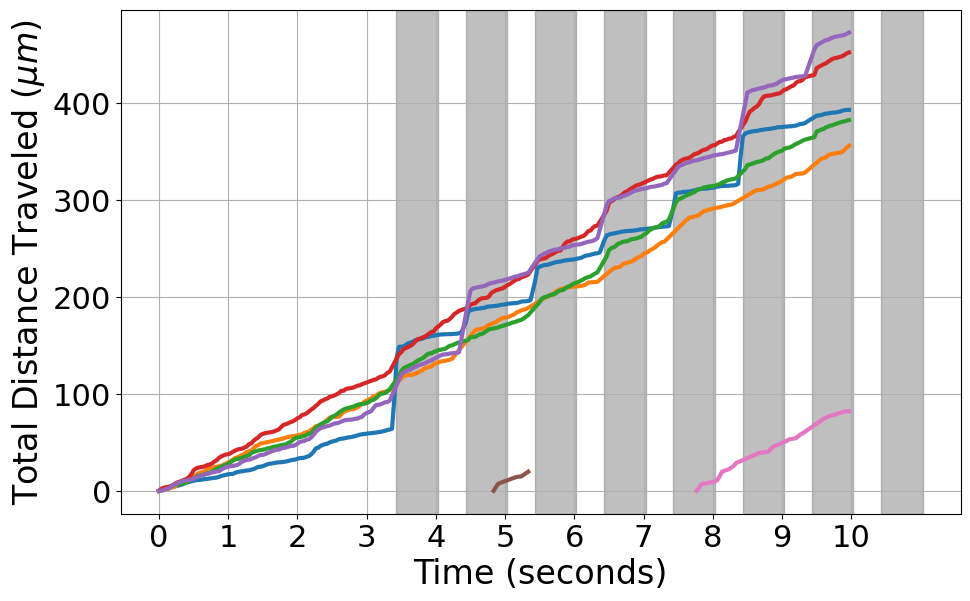

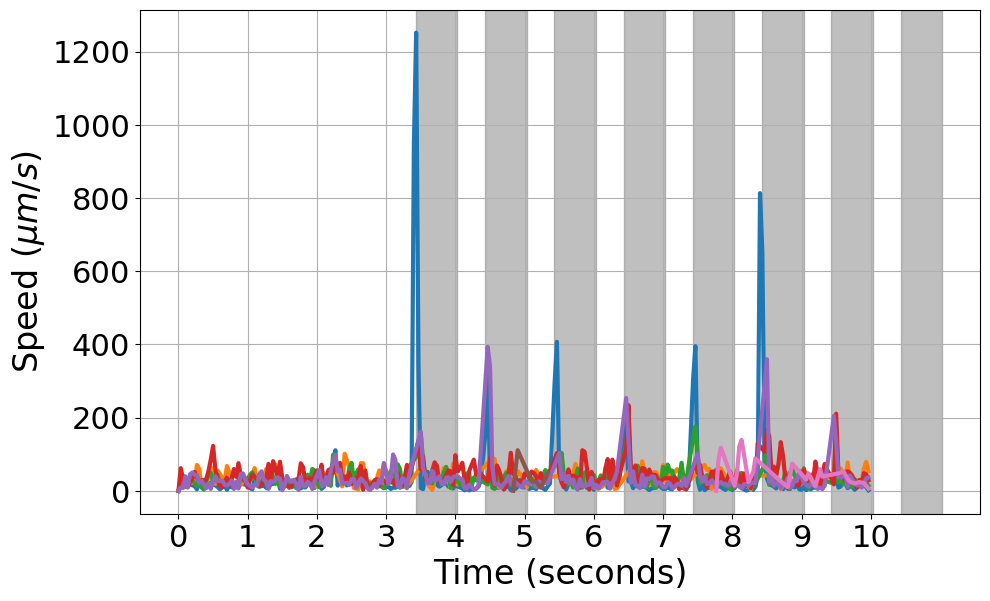

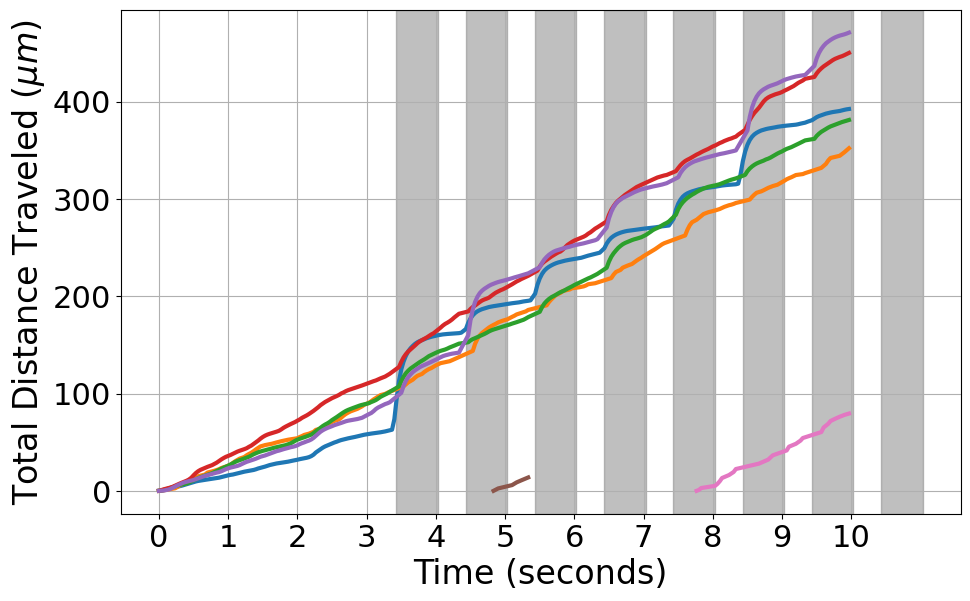

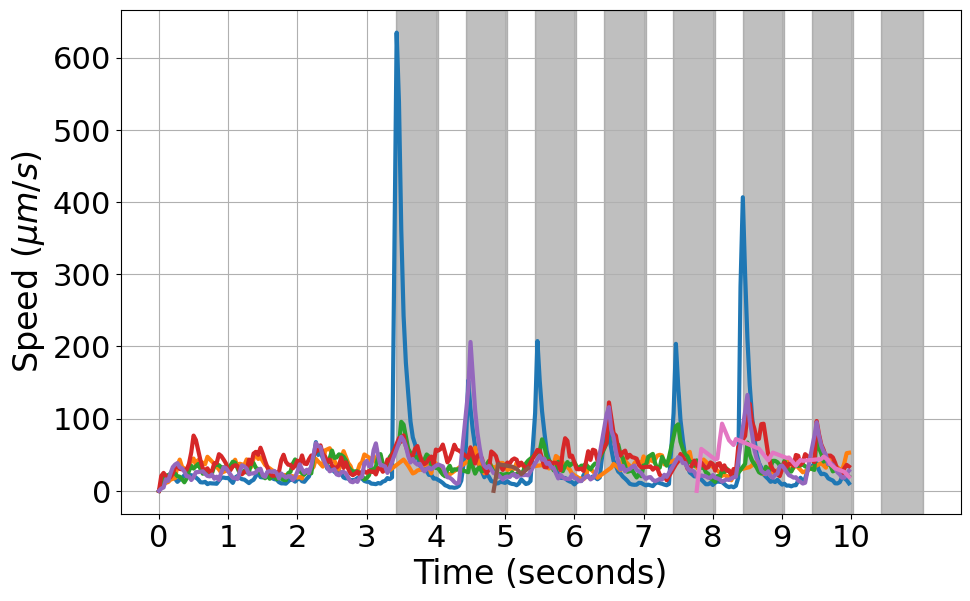

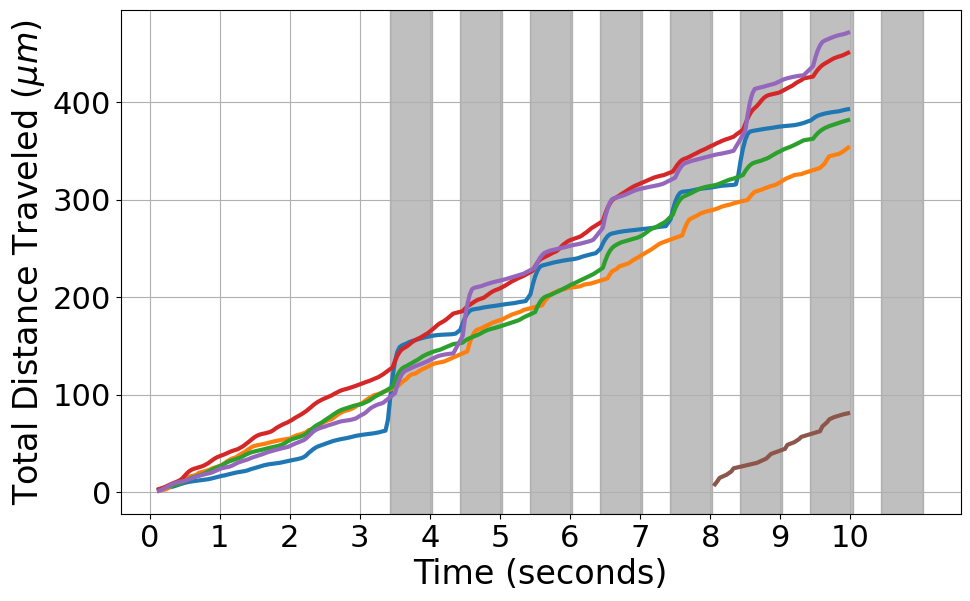

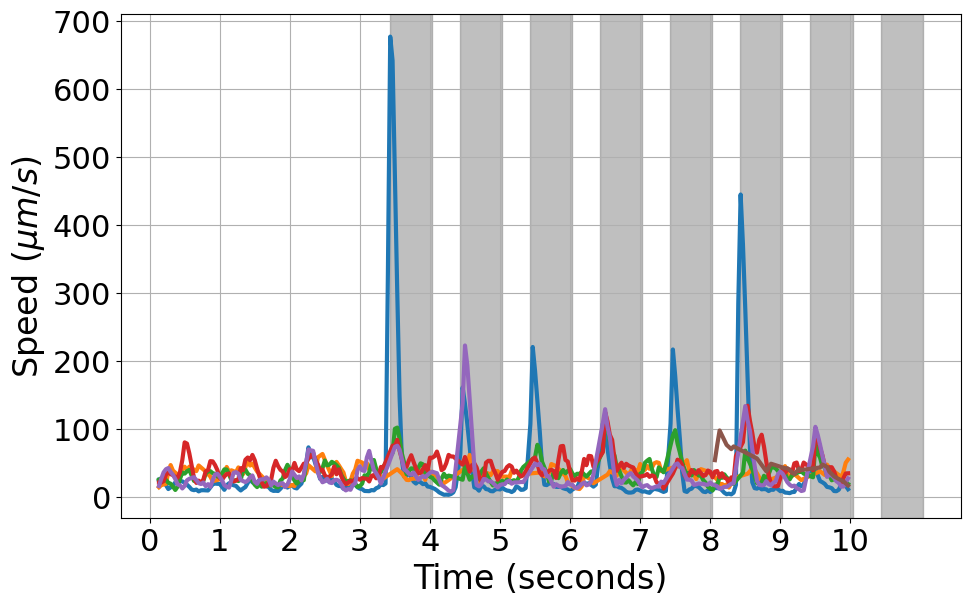

In [495]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import openpyxl
import matplotlib.pyplot as plt
import numpy as np

# Define analysis types and their corresponding DataFrame names
analysis_info = {
    'original': {
        'peaks_df': 'original_peaks_df',
        'velocity_stats': 'original_velocity_stats',
        'distance_col': 'total_distance_traveled',
        'speed_col': 'speed'
    },
    'ema': {
        'peaks_df': 'ema_speed_peaks_df',
        'velocity_stats': 'ema_velocity_stats',
        'distance_col': 'ema_total_distance',
        'speed_col': 'ema_speed'
    },
    'wma': {
        'peaks_df': 'wma_speed_peaks_df',
        'velocity_stats': 'wma_velocity_stats',
        'distance_col': 'wma_total_distance',
        'speed_col': 'wma_speed'
    }
}

# Function to create a new XML with specific particles and update the UltrasoundBurstFrame
def create_filtered_xml(xml_file_path, particle_numbers, output_path, hifu_burst_start):
    # Parse the original XML
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Find the <Particles> element
    particles_element = root.find('Particles')

    # Create a new root element
    new_root = ET.Element('ParticleData')

    # Append the updated UltrasoundBurstFrame element to the new root
    new_ultrasound_burst_frame_element = ET.SubElement(new_root, 'UltrasoundBurstFrame')
    new_ultrasound_burst_frame_element.text = str(hifu_burst_start * 30)

    # Create a new <Particles> element
    new_particles_element = ET.Element('Particles')

    # Iterate over each <Particle> element and filter by particle number
    for particle in particles_element.findall('Particle'):
        particle_number = int(particle.find('particle').text)
        if particle_number in particle_numbers:
            new_particles_element.append(particle)

    # Append the new <Particles> element to the new root
    new_root.append(new_particles_element)

    # Write the new tree to a file
    new_tree = ET.ElementTree(new_root)
    new_tree.write(output_path)
    
# Function to plot data
def plot_data(filtered_active_traj_filt, hifu_burst_start, max_time, analysis_type, with_legend=False, max_y_total_distance=None, max_y_speed=None):
    filtered_data = filtered_active_traj_filt[filtered_active_traj_filt['time'] <= max_time]
    
    speed_col = f'{analysis_type}_speed' if analysis_type != 'original' else 'speed'
    distance_col = f'{analysis_type}_total_distance' if analysis_type != 'original' else 'total_distance_traveled'
    
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    for particle in filtered_data['particle'].unique():
        particle_data = filtered_data[filtered_data['particle'] == particle]
        ax1.plot(particle_data['time'], particle_data[distance_col], label=f'Particle {particle}', linewidth=3)
    
    for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
        ax1.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)
    
    ax1.set_xlabel('Time (seconds)', fontsize=24)
    ax1.set_ylabel(r'Total Distance Traveled ($\mu m$)', fontsize=24)
    if with_legend:
        ax1.legend(fontsize=24)
    ax1.grid(True)
    ax1.set_xticks(np.arange(0, max_time + 1, 1))
    ax1.tick_params(axis='both', which='major', labelsize=22)
    plt.subplots_adjust(left=0.2, top=0.95)
    if max_y_total_distance is not None:
        ax1.set_ylim(top=max_y_total_distance)
    
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    for particle in filtered_data['particle'].unique():
        particle_data = filtered_data[filtered_data['particle'] == particle]
        ax2.plot(particle_data['time'], particle_data[speed_col], label=f'Particle {particle}', linewidth=3)
    
    for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
        ax2.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)
    
    ax2.set_xlabel('Time (seconds)', fontsize=24)
    ax2.set_ylabel('Speed ($\mu m/s$)', fontsize=24)
    if with_legend:
        ax2.legend(fontsize=24)
    ax2.grid(True)
    ax2.set_xticks(np.arange(0, max_time + 1, 1))
    ax2.tick_params(axis='both', which='major', labelsize=22)
    plt.subplots_adjust(left=0.2, top=0.95)
    if max_y_speed is not None:
        ax2.set_ylim(top=max_y_speed)

    return fig1, fig2

# Function to auto-fit column widths
def auto_fit_columns(workbook):
    for sheet_name in workbook.sheetnames:
        ws = workbook[sheet_name]
        for col in ws.columns:
            max_length = 0
            column = col[0].column_letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = (max_length + 2)
            ws.column_dimensions[column].width = adjusted_width
            
# Define analysis types
analysis_types = ['original', 'ema', 'wma']

# Create folder structure
main_folder = os.path.dirname(os.path.dirname(os.path.dirname(xml_file_path)))
compilation_folder = os.path.join(main_folder, 'Compilation')
plots_folder = os.path.join(compilation_folder, 'Compiled Plots')
xlsx_folder = os.path.join(compilation_folder, 'Compiled xlsx')
xml_updated_folder = os.path.join(compilation_folder, 'xml_updated')

for analysis_type in analysis_types:
    os.makedirs(os.path.join(plots_folder, f'{analysis_type.capitalize()} Plots'), exist_ok=True)
    os.makedirs(os.path.join(xlsx_folder, f'{analysis_type.capitalize()} xlsx'), exist_ok=True)
    os.makedirs(os.path.join(xml_updated_folder, f'{analysis_type.capitalize()} xmls'), exist_ok=True)

file_name_without_ext = os.path.splitext(os.path.basename(xml_file_path))[0]

# Process each analysis type
# Process each analysis type
for analysis_type, info in analysis_info.items():
    # Get the corresponding DataFrame and peaks DataFrame
    filtered_df = filtered_metrics[analysis_type]
    peaks_df = globals()[info['peaks_df']]
    velocity_stats = globals()[info['velocity_stats']]

    # Plot and save figures
    save_path_fig1 = os.path.normpath(os.path.join(plots_folder, f'{analysis_type.capitalize()} Plots', f'Total_Distance_Traveled_{analysis_type.capitalize()}_{file_name_without_ext}.png'))
    save_path_fig2 = os.path.normpath(os.path.join(plots_folder, f'{analysis_type.capitalize()} Plots', f'Speed_{analysis_type.capitalize()}_{file_name_without_ext}.png'))
    
    fig1, fig2 = plot_data(filtered_df, hifu_burst_start, max_time=10, analysis_type=analysis_type, with_legend=False)
    fig1.savefig(save_path_fig1, bbox_inches='tight', format='png', dpi=600)
    fig2.savefig(save_path_fig2, bbox_inches='tight', format='png', dpi=600)

    # Save Excel files
    xlsx_file_name = f"{file_name_without_ext}_{analysis_type}_metrics.xlsx"
    save_path_excel = os.path.normpath(os.path.join(xlsx_folder, f'{analysis_type.capitalize()} xlsx', xlsx_file_name))
    
    with pd.ExcelWriter(save_path_excel, engine='openpyxl') as writer:
        peaks_df.to_excel(writer, sheet_name='Peaks Raw', index=False)
        velocity_stats.to_excel(writer, sheet_name='Peaks Averaged', index=False)

    # Auto-fit columns
    wb = openpyxl.load_workbook(save_path_excel)
    auto_fit_columns(wb)
    wb.save(save_path_excel)

    # Save distance and speed metrics
    distance_speed_file_name = f"{file_name_without_ext}_{analysis_type}_distance_and_speed_metrics.xlsx"
    distance_speed_path_excel = os.path.normpath(os.path.join(xlsx_folder, f'{analysis_type.capitalize()} xlsx', distance_speed_file_name))

    filtered_df = filtered_df.drop_duplicates(subset=['frame', 'particle'])
    
    distance_col = info['distance_col']
    speed_col = info['speed_col']
    
    total_distance_traveled_df = filtered_df.pivot(index='frame', columns='particle', values=distance_col)
    speed_df = filtered_df.pivot(index='frame', columns='particle', values=speed_col)

    for df in [total_distance_traveled_df, speed_df]:
        df.columns = [f'Particle {i}' for i in df.columns]

    with pd.ExcelWriter(distance_speed_path_excel, engine='openpyxl') as writer:
        total_distance_traveled_df.to_excel(writer, sheet_name='Total Distance Traveled (µm)', index_label='Frame')
        speed_df.to_excel(writer, sheet_name='Speed (µm-s)', index_label='Frame')

    wb = openpyxl.load_workbook(distance_speed_path_excel)
    auto_fit_columns(wb)
    wb.save(distance_speed_path_excel)

    # Create filtered XML
    xml_output_path = os.path.join(xml_updated_folder, f'{analysis_type.capitalize()} xmls', f"{file_name_without_ext}_{analysis_type}_filtered.xml")
    create_filtered_xml(xml_file_path, peaks_df['Particle Number'].unique(), xml_output_path, hifu_burst_start)

    print(f"{analysis_type.capitalize()} processing complete.")
    print(f"Filtered XML file created at: {xml_output_path}")
    print(f"{analysis_type.capitalize()} Total Distance Traveled and Speed file saved at: {distance_speed_path_excel}")
    print(f"{analysis_type.capitalize()} figures saved at: {save_path_fig1} and {save_path_fig2}")
    print()

print("All processing complete.")

